Comparing different kernel functions for their performance in predicting the true signal from noisy observations of a linearly chirped sinusoidal sequence
---------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.compat.v2.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

In [9]:
#function to create the chirp signal

def chirp(x, c, f):
    ft = (x*c) + f
    c_sig = np.sin(2*np.pi*ft*x)
    return c_sig


In [96]:
#create the observation points and instantiate the operating conditions

index_points = np.arange(0,4,0.005,).astype(np.float64)
index_points = index_points.reshape(800,1)

SNR = np.array([0.5,2,5,10])
signal_amp = 1;
Ps = signal_amp**2
Pn = (Ps*10)**(-SNR/10)
num_points = np.array([8,16,32,64,128,256,512,1024])

#gradient descent parameters
num_iters = 100
optimizer = tf.optimizers.Adam(learning_rate=0.05)
        

In [ ]:
x_vals = []
#output = np.array([4,8])
output = []

for i in range(len(num_points)):
    x_vals.append(np.array(np.arange(0,4,4/num_points[i],).astype(np.float64)))
    x_vals[i] = x_vals[i].reshape(num_points[i],1)

    
for k in range(len(SNR)):
    output.append([])
    for i in range(len(num_points)):
        output[k].append(chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                       num_points[i]).reshape(num_points[i],1))
        output[k][i] = output[k][i].reshape(num_points[i],)


--------------------------
Varying SNR and Obs with different kernel functions
-----------------------------

------------------------------------

(Squared-Exponential  x  Periodic) + Linear

In [115]:
mc_norm_error_SePeL = np.zeros([len(SNR),len(num_points)])
mean_line_SePeL = np.zeros([len(SNR),len(num_points),800])
std_SePeL = np.zeros([len(SNR),len(num_points),800])

for k in range(len(SNR)):
    for i in range(len(num_points)):

        def build_gp_model(amplitude, length_scale, observation_noise_variance, bias_variance, slope_variance):

            kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
            kernel_2 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
            kernel_3 = tfk.Linear(bias_variance=bias_variance, slope_variance=slope_variance)
            model_kernel = (kernel_1*kernel_2)+kernel_3

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals[i],
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'slope_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'bias_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })

        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        slope_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='slope_variance_var',
            dtype=tf.float64)

        bias_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='bias_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var,
                               slope_variance_var,
                               bias_variance_var]]


        @tf.function(autograph=False, experimental_compile=False)
        def target_log_prob(amplitude, length_scale, observation_noise_variance, slope_variance, bias_variance):
            return gp_joint_model.log_prob({
              'amplitude': amplitude,
              'length_scale': length_scale,
              'observation_noise_variance': observation_noise_variance,
              'slope_variance': slope_variance,
              'bias_variance': bias_variance,
              'observations': output[k][i]
          })


        
        for j in range(num_iters):
            with tf.GradientTape() as tape:
                loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var,
                                       slope_variance_var, bias_variance_var)
                grads = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(grads, trainable_variables))


        opt_kernel_1 = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)
        opt_kernel_2 = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)
        opt_kernel_3 = tfk.Linear(slope_variance=slope_variance_var, bias_variance = bias_variance_var)
        optimized_kernel = (opt_kernel_1*opt_kernel_2) + opt_kernel_3


        norm_error = np.zeros([10])
        #start loopin
        for n in range(10):

            validation_output = chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points[i]).reshape(num_points[i],1)
            validation_output = validation_output.reshape(num_points[i],)


            gprm_SePeL = tfd.GaussianProcessRegressionModel(
                kernel = optimized_kernel,
                index_points = index_points,
                observation_index_points = x_vals[i],
                observations = validation_output,
                observation_noise_variance = observation_noise_variance_var,
                predictive_noise_variance=0.)

            mean_line = gprm_SePeL.mean_fn(index_points)

            norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, 0.5, 0.5).reshape(800))**2))

        mean_line_SePeL[k,i,:] = gprm_SePeL.mean_fn(index_points)
        std_SePeL[k,i,:] = gprm_SePeL.stddev()
        mc_norm_error_SePeL[k,i] = np.mean(norm_error)

Text(0.5, 1.0, '(Se x Pe) + L   - SNR = 5, Observations = 256')

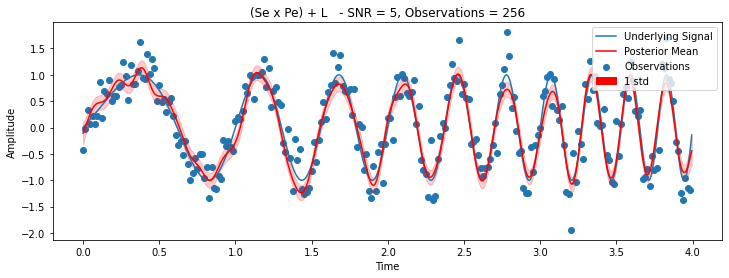

In [116]:
plt.figure(figsize=(12, 4))
plt.plot(index_points, chirp(index_points,0.5, 0.5),label='Underlying Signal')

plt.scatter(x_vals[5], output[3][5], label='Observations')

plt.plot(index_points, mean_line_SePeL[3][5], c='r', label='Posterior Mean')
plt.fill_between(index_points.reshape(-1),mean_line_SePeL[3,5] + std_SePeL[3,5] , 
                 mean_line_SePeL[3,5] - std_SePeL[3,5], color = 'r', alpha = 0.2, label='1 std')
    
leg = plt.legend(loc='upper right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("(Se x Pe) + L   - SNR = 5, Observations = 256")

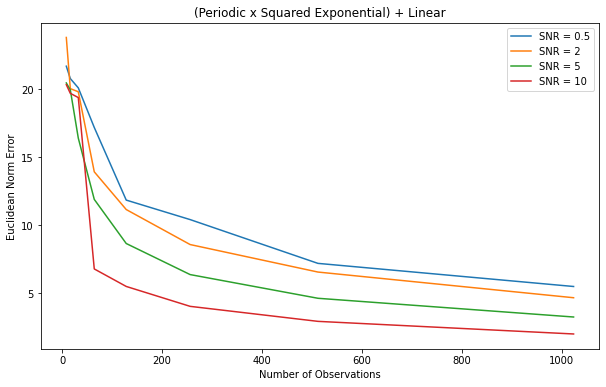

In [117]:
fig1 = plt.figure(figsize = (10,6))
plt.plot(num_points, mc_norm_error_SePeL[0], label = 'SNR = 0.5')
plt.plot(num_points, mc_norm_error_SePeL[1], label = 'SNR = 2')
plt.plot(num_points, mc_norm_error_SePeL[2], label = 'SNR = 5')
plt.plot(num_points, mc_norm_error_SePeL[3], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Number of Observations')
plt.ylabel('Euclidean Norm Error')
plt.title('(Periodic x Squared Exponential) + Linear')

fig1.savefig('SExPe+Lin.png')

In [118]:
mc_norm_error_SePeL

array([[21.70031988, 20.79295922, 20.10883205, 17.19793607, 11.8613805 ,
        10.42864594,  7.21075502,  5.51164402],
       [23.81309618, 20.05331228, 19.82132627, 13.93859393, 11.16681813,
         8.59412909,  6.57290976,  4.68579447],
       [20.46989569, 19.96462024, 16.41515149, 11.9122063 ,  8.67055054,
         6.38710811,  4.6454333 ,  3.26938178],
       [20.34386632, 19.70671781, 19.39632983,  6.80115136,  5.51514906,
         4.05236455,  2.94942305,  2.02231865]])

--------------

Periodic Kernel

-----------------


In [119]:
mc_norm_error_Pe = np.zeros([len(SNR),len(num_points)])
mean_line_Pe = np.zeros([len(SNR),len(num_points),800])
std_Pe = np.zeros([len(SNR),len(num_points),800])

for k in range(len(SNR)):
    for i in range(len(num_points)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals[i],
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        @tf.function(autograph=False, experimental_compile=False)
        def target_log_prob(amplitude, length_scale, observation_noise_variance):
            return gp_joint_model.log_prob({
              'amplitude': amplitude,
              'length_scale': length_scale,
              'observation_noise_variance': observation_noise_variance,
              'observations': output[k][i]
            })

        
        for j in range(num_iters):
            with tf.GradientTape() as tape:
                loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                grads = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(grads, trainable_variables))


        optimized_kernel = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)      

        norm_error = np.zeros([10])
        #start loopin
        for n in range(10):

            validation_output = chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points[i]).reshape(num_points[i],1)
            validation_output = validation_output.reshape(num_points[i],)


            gprm_Pe = tfd.GaussianProcessRegressionModel(
                kernel = optimized_kernel,
                index_points = index_points,
                observation_index_points = x_vals[i],
                observations = validation_output,
                observation_noise_variance = observation_noise_variance_var,
                predictive_noise_variance=0.)

            mean_func = gprm_Pe.mean_fn
            mean_line = mean_func(index_points)

            norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, 0.5, 0.5).reshape(800))**2))

        mean_line_Pe[k,i,:] = gprm_Pe.mean_fn(index_points)
        std_Pe[k,i,:] = gprm_Pe.stddev()
        mc_norm_error_Pe[k,i] = np.mean(norm_error)

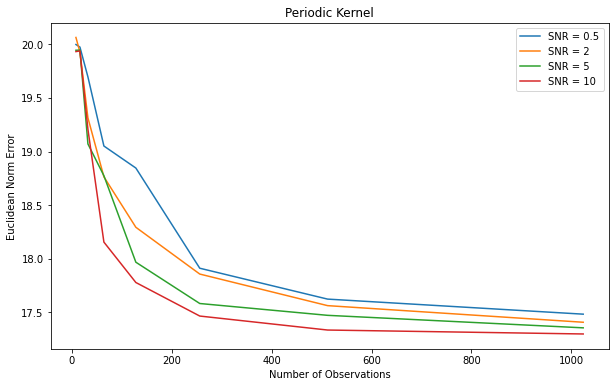

In [120]:
fig2 = plt.figure(figsize = (10,6))
plt.plot(num_points, mc_norm_error_Pe[0], label = 'SNR = 0.5')
plt.plot(num_points, mc_norm_error_Pe[1], label = 'SNR = 2')
plt.plot(num_points, mc_norm_error_Pe[2], label = 'SNR = 5')
plt.plot(num_points, mc_norm_error_Pe[3], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Number of Observations')
plt.ylabel('Euclidean Norm Error')
plt.title('Periodic Kernel')

fig2.savefig('Pe.png')

In [121]:
mc_norm_error_Pe

array([[19.9981334 , 19.97423409, 19.69608213, 19.0514139 , 18.84608712,
        17.91155285, 17.62355328, 17.483089  ],
       [20.06390863, 19.92724818, 19.3139327 , 18.76388206, 18.2934598 ,
        17.85720778, 17.56261828, 17.40762933],
       [19.94451431, 19.94587052, 19.07092707, 18.77450814, 17.9677335 ,
        17.58249742, 17.47223747, 17.35557598],
       [19.93204957, 19.93823898, 19.20684983, 18.15524698, 17.77842663,
        17.46553905, 17.33506588, 17.29832389]])

Text(0.5, 1.0, '(Pe Kernel)   - SNR = 5, Observations = 256')

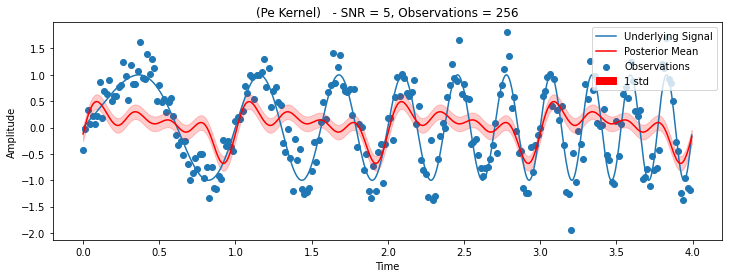

In [122]:
plt.figure(figsize=(12, 4))
plt.plot(index_points, chirp(index_points,0.5, 0.5),label='Underlying Signal')

plt.scatter(x_vals[5], output[3][5], label='Observations')

plt.plot(index_points, mean_line_Pe[3,5], c='r', label='Posterior Mean')
plt.fill_between(index_points.reshape(-1),mean_line_Pe[3,5] + std_Pe[3,5] , 
                 mean_line_Pe[3,5] - std_Pe[3,5], color = 'r', alpha = 0.2, label='1 std')
    
leg = plt.legend(loc='upper right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("(Pe Kernel)   - SNR = 5, Observations = 256")

---------------

Squared Exponential Kernel

------------------


In [123]:
mc_norm_error_Se = np.zeros([len(SNR),len(num_points)])
mean_line_Se = np.zeros([len(SNR),len(num_points),800])
std_Se = np.zeros([len(SNR),len(num_points),800])

for k in range(len(SNR)):
    for i in range(len(num_points)):


        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            model_kernel = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals[i],
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        @tf.function(autograph=False, experimental_compile=False)
        def target_log_prob(amplitude, length_scale, observation_noise_variance):
            return gp_joint_model.log_prob({
              'amplitude': amplitude,
              'length_scale': length_scale,
              'observation_noise_variance': observation_noise_variance,
              'observations': output[k][i]
            })

        
        for j in range(num_iters):
            with tf.GradientTape() as tape:
                loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                grads = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(grads, trainable_variables))


        optimized_kernel = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)      

        norm_error = np.zeros([10])
        #start loopin
        for n in range(10):

            validation_output = chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points[i]).reshape(num_points[i],1)
            validation_output = validation_output.reshape(num_points[i],)


            gprm_Se = tfd.GaussianProcessRegressionModel(
                kernel = optimized_kernel,
                index_points = index_points,
                observation_index_points = x_vals[i],
                observations = validation_output,
                observation_noise_variance = observation_noise_variance_var,
                predictive_noise_variance=0.)

            mean_func = gprm_Se.mean_fn
            mean_line = mean_func(index_points)

            norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, 0.5, 0.5).reshape(800))**2))

        mean_line_Se[k,i,:] = gprm_Se.mean_fn(index_points)
        std_Se[k,i,:] = gprm_Se.stddev()
        mc_norm_error_Se[k,i] = np.mean(norm_error)

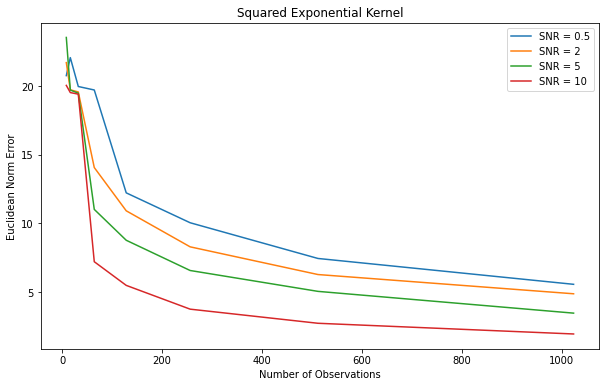

In [124]:
fig3 = plt.figure(figsize = (10,6))
plt.plot(num_points, mc_norm_error_Se[0], label = 'SNR = 0.5')
plt.plot(num_points, mc_norm_error_Se[1], label = 'SNR = 2')
plt.plot(num_points, mc_norm_error_Se[2], label = 'SNR = 5')
plt.plot(num_points, mc_norm_error_Se[3], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Number of Observations')
plt.ylabel('Euclidean Norm Error')
plt.title('Squared Exponential Kernel')

fig3.savefig('SE.png')

Text(0.5, 1.0, '(Se Kernel)   - SNR = 5, Observations = 256')

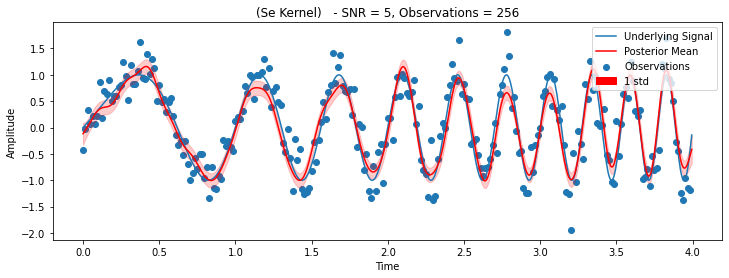

In [126]:
plt.figure(figsize=(12, 4))
plt.plot(index_points, chirp(index_points,0.5, 0.5),label='Underlying Signal')

plt.scatter(x_vals[5], output[3][5], label='Observations')

plt.plot(index_points, mean_line_Se[3,5], c='r', label='Posterior Mean')
plt.fill_between(index_points.reshape(-1),mean_line_Se[3,5] + std_Se[3,5] , 
                 mean_line_Se[3,5] - std_Se[3,5], color = 'r', alpha = 0.2, label='1 std')
    
leg = plt.legend(loc='upper right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("(Se Kernel)   - SNR = 5, Observations = 256")

In [ ]:
mc_norm_error_Se

----------------------------

Squared Exponential x Periodic

-------------------------

In [128]:
mc_norm_error_SePe = np.zeros([len(SNR),len(num_points)])
mean_line_SePe = np.zeros([len(SNR),len(num_points),800])
std_SePe = np.zeros([len(SNR),len(num_points),800])

for k in range(len(SNR)):
    for i in range(len(num_points)):

        def build_gp_model(amplitude, length_scale, observation_noise_variance):

            kernel1 = tfk.ExpSinSquared(amplitude = amplitude, length_scale = length_scale)
            kernel2 = tfk.ExponentiatedQuadratic(amplitude = amplitude, length_scale = length_scale)
            model_kernel = kernel1*kernel2

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals[i],
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               observation_noise_variance_var]]

        @tf.function(autograph=False, experimental_compile=False)
        def target_log_prob(amplitude, length_scale, observation_noise_variance):
            return gp_joint_model.log_prob({
              'amplitude': amplitude,
              'length_scale': length_scale,
              'observation_noise_variance': observation_noise_variance,
              'observations': output[k][i]
            })

        
        for j in range(num_iters):
            with tf.GradientTape() as tape:
                loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
                grads = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(grads, trainable_variables))


        
        opt_kernel1 = tfk.ExpSinSquared(amplitude = amplitude_var, length_scale = length_scale_var)
        opt_kernel2 = tfk.ExponentiatedQuadratic(amplitude = amplitude_var, length_scale = length_scale_var)
        optimized_kernel = opt_kernel1*opt_kernel2      

        norm_error = np.zeros([10])
        #start loopin
        for n in range(10):

            validation_output = chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points[i]).reshape(num_points[i],1)
            validation_output = validation_output.reshape(num_points[i],)


            gprm_SePe = tfd.GaussianProcessRegressionModel(
                kernel = optimized_kernel,
                index_points = index_points,
                observation_index_points = x_vals[i],
                observations = validation_output,
                observation_noise_variance = observation_noise_variance_var,
                predictive_noise_variance=0.)

            mean_func = gprm_SePe.mean_fn
            mean_line = mean_func(index_points)

            norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, 0.5, 0.5).reshape(800))**2))

        mean_line_SePe[k,i,:] = gprm_SePe.mean_fn(index_points)
        std_SePe[k,i,:] = gprm_SePe.stddev()
        mc_norm_error_SePe[k,i] = np.mean(norm_error)

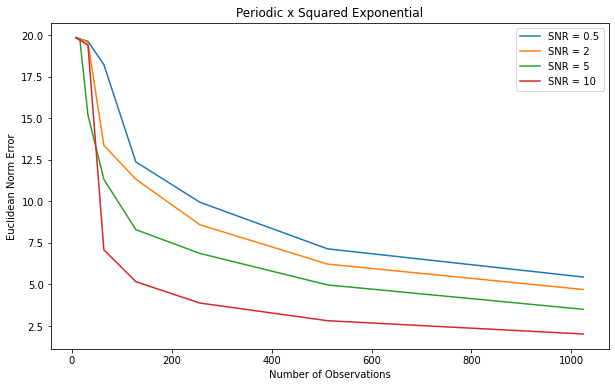

In [129]:
fig4 = plt.figure(figsize = (10,6))
plt.plot(num_points, mc_norm_error_SePe[0], label = 'SNR = 0.5')
plt.plot(num_points, mc_norm_error_SePe[1], label = 'SNR = 2')
plt.plot(num_points, mc_norm_error_SePe[2], label = 'SNR = 5')
plt.plot(num_points, mc_norm_error_SePe[3], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Number of Observations')
plt.ylabel('Euclidean Norm Error')
plt.title('Periodic x Squared Exponential')

fig4.savefig('PeSE.png')

In [130]:
mc_norm_error_SePe

array([[19.82927105, 19.76894861, 19.62856316, 18.21908383, 12.37346584,
         9.95034625,  7.14328115,  5.44928821],
       [19.82722483, 19.78569062, 19.56133961, 13.36414051, 11.33426333,
         8.59656995,  6.22740301,  4.70057906],
       [19.85761541, 19.69670085, 15.20165531, 11.32108493,  8.29909386,
         6.87187215,  4.9748077 ,  3.50828346],
       [19.84507482, 19.69619416, 19.39932959,  7.08428301,  5.1692054 ,
         3.88550926,  2.82164751,  2.02424947]])

Text(0.5, 1.0, '(Se x Pe Kernel)   - SNR = 5, Observations = 256')

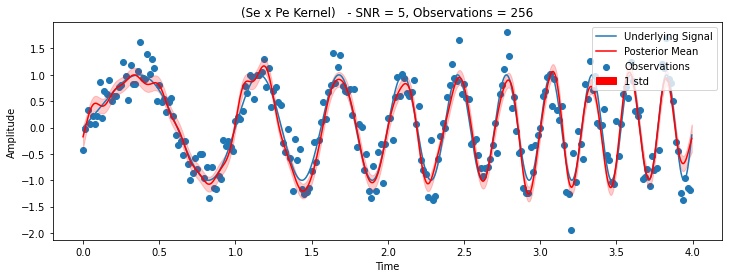

In [131]:
plt.figure(figsize=(12, 4))
plt.plot(index_points, chirp(index_points,0.5, 0.5),label='Underlying Signal')

plt.scatter(x_vals[5], output[3][5], label='Observations')

plt.plot(index_points, mean_line_SePe[3,5], c='r', label='Posterior Mean')
plt.fill_between(index_points.reshape(-1),mean_line_SePe[3,5] + std_SePe[3,5] , 
                 mean_line_SePe[3,5] - std_SePe[3,5], color = 'r', alpha = 0.2, label='1 std')
    
leg = plt.legend(loc='upper right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("(Se x Pe Kernel)   - SNR = 5, Observations = 256")

-----------------------------
Rational Quadratic Kernel

-----------------------------

In [134]:
mc_norm_error_Rq = np.zeros([len(SNR),len(num_points)])
mean_line_Rq = np.zeros([len(SNR),len(num_points),800])
std_Rq = np.zeros([len(SNR),len(num_points),800])

for k in range(len(SNR)):
    for i in range(len(num_points)):


        def build_gp_model(amplitude, length_scale, scale_mixture_rate, observation_noise_variance):

            model_kernel = tfk.RationalQuadratic(amplitude = amplitude, 
                                         length_scale = length_scale, scale_mixture_rate = scale_mixture_rate)

            return tfd.GaussianProcess(
              kernel = model_kernel,
              index_points = x_vals[i],
              observation_noise_variance = observation_noise_variance)

        gp_joint_model = tfd.JointDistributionNamed({
            'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'scale_mixture_rate': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
            'observations': build_gp_model,
        })
        

        constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

        amplitude_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='amplitude',
            dtype=tf.float64)

        length_scale_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='length_scale',
            dtype=tf.float64)

        scale_mixture_rate_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='scale_mixture_rate',
            dtype=tf.float64)
        
        observation_noise_variance_var = tfp.util.TransformedVariable(
            initial_value=1.,
            bijector=constrain_positive,
            name='observation_noise_variance_var',
            dtype=tf.float64)

        trainable_variables = [v.trainable_variables[0] for v in 
                               [amplitude_var,
                               length_scale_var,
                               scale_mixture_rate_var,
                               observation_noise_variance_var]]

        @tf.function(autograph=False, experimental_compile=False)
        def target_log_prob(amplitude, length_scale, scale_mixture_rate, observation_noise_variance):
            return gp_joint_model.log_prob({
              'amplitude': amplitude,
              'length_scale': length_scale,
              'scale_mixture_rate': scale_mixture_rate,
              'observation_noise_variance': observation_noise_variance,
              'observations': output[k][i]
            })

        
        for j in range(num_iters):
            with tf.GradientTape() as tape:
                loss = -target_log_prob(amplitude_var, length_scale_var, 
                                        scale_mixture_rate_var, observation_noise_variance_var)
                grads = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(grads, trainable_variables))


        optimized_kernel = tfk.RationalQuadratic(amplitude = amplitude_var, 
                                     length_scale = length_scale_var, scale_mixture_rate = scale_mixture_rate_var)      

        norm_error = np.zeros([10])
        #start loopin
        for n in range(10):

            validation_output = chirp(x_vals[i], 0.5, 0.5) + np.random.normal(0, np.sqrt(Pn[k]), 
                                                                              num_points[i]).reshape(num_points[i],1)
            validation_output = validation_output.reshape(num_points[i],)


            gprm_Rq = tfd.GaussianProcessRegressionModel(
                kernel = optimized_kernel,
                index_points = index_points,
                observation_index_points = x_vals[i],
                observations = validation_output,
                observation_noise_variance = observation_noise_variance_var,
                predictive_noise_variance=0.)

            mean_func = gprm_Rq.mean_fn
            mean_line = mean_func(index_points)

            norm_error[n] = np.sqrt(np.sum((mean_line - chirp(index_points, 0.5, 0.5).reshape(800))**2))

        mean_line_Rq[k,i,:] = gprm_Rq.mean_fn(index_points)
        std_Rq[k,i,:] = gprm_Rq.stddev()
        mc_norm_error_Rq[k,i] = np.mean(norm_error)

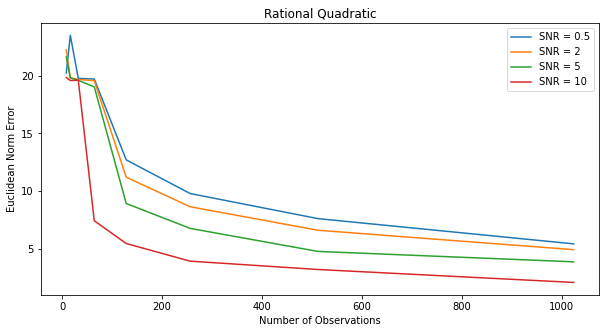

In [138]:
fig5 = plt.figure(figsize = (10,5))
plt.plot(num_points, mc_norm_error_Rq[0], label = 'SNR = 0.5')
plt.plot(num_points, mc_norm_error_Rq[1], label = 'SNR = 2')
plt.plot(num_points, mc_norm_error_Rq[2], label = 'SNR = 5')
plt.plot(num_points, mc_norm_error_Rq[3], label = 'SNR = 10')

leg = plt.legend(loc='upper right')
plt.xlabel('Number of Observations')
plt.ylabel('Euclidean Norm Error')
plt.title('Rational Quadratic')

fig4.savefig('RQ.png')

In [137]:
mc_norm_error_Rq

array([[20.24210867, 23.49066189, 19.76611809, 19.71533008, 12.71345427,
         9.80427579,  7.63217232,  5.45033898],
       [22.23492268, 19.80458455, 19.68310244, 19.56646118, 11.2169569 ,
         8.66012578,  6.62608868,  4.9474766 ],
       [21.62131876, 19.81538151, 19.60079289, 19.02897817,  8.94036201,
         6.78844017,  4.79496225,  3.89460868],
       [19.84279669, 19.58376434, 19.60638217,  7.44818661,  5.47979401,
         3.95374222,  3.23084068,  2.11046809]])

Text(0.5, 1.0, '(RQ Kernel)   - SNR = 5, Observations = 256')

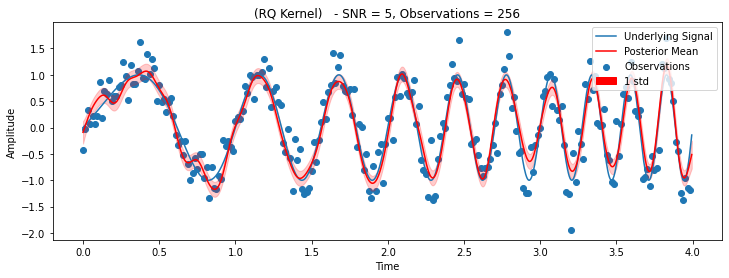

In [136]:
plt.figure(figsize=(12, 4))
plt.plot(index_points, chirp(index_points,0.5, 0.5),label='Underlying Signal')

plt.scatter(x_vals[5], output[3][5], label='Observations')

plt.plot(index_points, mean_line_Rq[3,5], c='r', label='Posterior Mean')
plt.fill_between(index_points.reshape(-1),mean_line_Rq[3,5] + std_Rq[3,5] , 
                 mean_line_Rq[3,5] - std_Rq[3,5], color = 'r', alpha = 0.2, label='1 std')
    
leg = plt.legend(loc='upper right')

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("(RQ Kernel)   - SNR = 5, Observations = 256")